In [1]:
import pandas as pd
import numpy as np

# Constants

In [2]:
# IMPL_PATH='/content/drive/Shareddrives/FYP/FYP-Machine Learning Forecasting for Market Movements'

# Data Import

In [3]:
# from google.colab import drive

# drive.mount("/content/drive")

In [4]:
df=pd.read_csv("../data/df_pca.csv")
df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,Close
0,8.755097,-1.212193,-1.276463,1.159765,-0.012276,2.765831,-1.004652,-0.611003,-1.259797,0.463008,...,-1.088724,-0.454095,0.605422,-0.218074,0.247818,0.173192,-0.143042,0.181079,-0.355859,13761.50
1,8.759735,-1.870156,-0.802976,1.296984,-0.032890,2.083716,0.314620,0.845468,0.144904,-1.360242,...,0.782829,-1.171770,-0.327405,0.283600,0.611910,0.080948,-0.041990,0.130494,-0.470439,13792.66
2,8.791509,-1.512459,-0.746779,0.130166,0.283933,-1.928331,0.586964,0.394864,-0.583210,0.617182,...,-0.445035,-1.392125,0.829706,0.225582,0.841628,0.206173,-0.042424,0.301000,-0.439536,13792.35
3,8.722170,-1.996410,-1.028591,0.480685,0.387770,-0.550079,2.162787,0.451984,0.378492,0.663118,...,0.361753,-0.559850,1.202855,0.323511,0.856800,0.149817,-0.124268,0.159326,-0.513975,13799.99
4,8.764059,-1.828420,-0.782719,0.153728,0.359551,3.090102,0.080951,-0.877918,0.940671,0.732906,...,0.075917,-0.864233,1.571507,0.271791,0.882637,0.272270,-0.129260,0.341953,-0.457991,13800.65


In [5]:
def NaNCheck(data):
  return data.isnull().sum()[data.isnull().sum()>0]

# Benchmark 2: LSTM Model
https://github.com/ChickenBenny/Stock-prediction-with-GAN-and-WGAN

In [6]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

#### Sliding Window

In [7]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

tmp_x = [0,1,2,3,4]

tmp_y = [5]

tmy_y_gan = [0,1,2,3,4,5]

#### HyperParameters

In [8]:
sliding_window_size = 10
testing_duration = 2016
training_duration = 2016
sm_threshold = 50
# 30d=8640, 7d=2016, 1d=288

#### Train Test Split

In [9]:
labels_df = df["Close"]
features_df = df.drop(columns=["Close"])

train_x = features_df.iloc[:training_duration]
train_y = labels_df.iloc[:training_duration]

test_x = features_df.iloc[training_duration:training_duration+testing_duration]
test_y = labels_df.iloc[training_duration:training_duration+testing_duration]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (2016, 21) trainY: (2016,)
testX: (2016, 21) testY: (2016,)


In [10]:
x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.values.reshape(-1, 1))
test_y = y_scaler.transform(test_y.values.reshape(-1, 1))

In [11]:
print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (2016, 21) trainY: (2016, 1)
testX: (2016, 21) testY: (2016, 1)


In [12]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, sliding_window_size)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, sliding_window_size)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')

train_x: torch.Size([2006, 10, 21]) train_y: torch.Size([2006, 1]) train_y_gan: torch.Size([2006, 11, 1])
test_x: torch.Size([2006, 10, 21]) test_y: torch.Size([2006, 1]) test_y_gan: torch.Size([2006, 11, 1])


## Model Implementation

In [13]:
class Generator(nn.Module):
  def __init__(self, input_size):
    super().__init__()

    # 3 LSTM layers, input_size = features
    self.lstm_1 = nn.LSTM(input_size, 1024, batch_first=True)
    self.lstm_2 = nn.LSTM(1024, 512, batch_first=True)
    self.lstm_3 = nn.LSTM(512, 256, batch_first=True)

    # 3 Dense Layers
    self.linear_1 = nn.Linear(256, 128)
    self.linear_2 = nn.Linear(128, 64)
    self.linear_3 = nn.Linear(64, 1)

    self.dropout = nn.Dropout(0.2)
    self.tanh = nn.Tanh()


  def forward(self, x,use_cuda=1):
    device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

    # initial hidden state and cell state for the 1st LSTM Layer
    h0 = torch.zeros(1, x.size(0), 1024).to(device)
    c0 = torch.zeros(1, x.size(0), 1024).to(device)

    out_lstm_1, (h1, c1) = self.lstm_1(x, (h0, c0))
    out_lstm_1 = self.dropout(out_lstm_1)

    # initial hidden state and cell state for the 2nd LSTM Layer
    h2 = torch.zeros(1, x.size(0), 512).to(device)
    c2 = torch.zeros(1, x.size(0), 512).to(device)

    out_lstm_2, (h3, c3) = self.lstm_2(out_lstm_1, (h2, c2))
    out_lstm_2 = self.dropout(out_lstm_2)

    # initial hidden state and cell state for the 3rd LSTM Layer
    h4 = torch.zeros(1, x.size(0), 256).to(device)
    c4 = torch.zeros(1, x.size(0), 256).to(device)

    out_lstm_3, (h5, c5) = self.lstm_3(out_lstm_2, (h4, c4))
    out_lstm_3 = self.dropout(out_lstm_3)

    out_dense_1 = self.linear_1(out_lstm_3[:, -1, :])
    out_dense_2 = self.linear_2(out_dense_1)
    out_dense_3 = self.linear_3(out_dense_2)

    return out_dense_3

    # x: torch.Size([128,3,21])

    # out_gru_1:  torch.Size([128, 3, 1024])
    # out_gru_2:  torch.Size([128, 3, 512])
    # out_gru_3:  torch.Size([128, 3, 256])

    # out_dense_1:  torch.Size([128, 128])
    # out_dense_2:  torch.Size([128, 64])
    # out_dense_3:  torch.Size([128, 1])

In [14]:
# x_scaler = MinMaxScaler(feature_range = (0, 1))
# y_scaler = MinMaxScaler(feature_range = (0, 1))

In [15]:
train_y_slide.shape

torch.Size([2006, 1])

In [16]:
use_cuda = 1
cuda = torch.cuda.is_available()
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.000164
num_epochs = 300

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_slide), batch_size = batch_size, shuffle = False)
# x = [batch_size,sliding_window,features]
# y = [batch_size,sliding_window+1,1(close value)]

# Give number of features to the G
model = Generator(train_x.shape[1]).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    loss_ = []
    y_pred = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)
        y_train_pred = model(x)
        loss = nn.functional.mse_loss(y_train_pred, y)
        loss_.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

[1/300] Loss: 2.3322551178280264
[2/300] Loss: 5.414355185581371
[3/300] Loss: 2.568186496384442
[4/300] Loss: 1.2561311600729823
[5/300] Loss: 2.718623678199947
[6/300] Loss: 1.6388829872012138
[7/300] Loss: 1.8701764210127294
[8/300] Loss: 1.8986091208644211
[9/300] Loss: 1.8153893649578094
[10/300] Loss: 1.8327062497846782
[11/300] Loss: 1.8136138855479658
[12/300] Loss: 1.8185470085591078
[13/300] Loss: 1.792293603066355
[14/300] Loss: 1.806660080794245
[15/300] Loss: 1.7785782399587333
[16/300] Loss: 1.7627017754130065
[17/300] Loss: 1.7762704826891422
[18/300] Loss: 1.7521399157121778
[19/300] Loss: 1.7625922206789255
[20/300] Loss: 1.7576749939471483
[21/300] Loss: 1.7434606300666928
[22/300] Loss: 1.732235581614077
[23/300] Loss: 1.7440566485747695
[24/300] Loss: 1.719827953260392
[25/300] Loss: 1.713001907337457
[26/300] Loss: 1.712826607748866
[27/300] Loss: 1.6828454281203449
[28/300] Loss: 1.6862394288182259
[29/300] Loss: 1.670933504588902
[30/300] Loss: 1.6305418526753783

Text(0.5, 0, 'Nr Epoches')

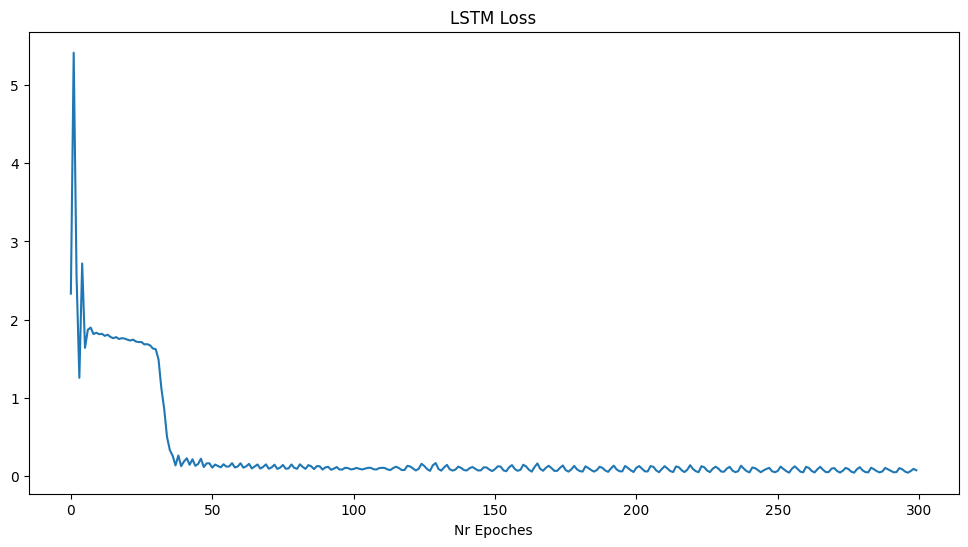

In [17]:
plt.figure(figsize = (12, 6))
plt.plot(hist, label = 'Loss')
plt.title('LSTM Loss')
plt.xlabel('Nr Epoches')

In [18]:
model.eval()
pred_y_train = model(train_x_slide.to(device))
pred_y_test = model(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:158.5341178284009


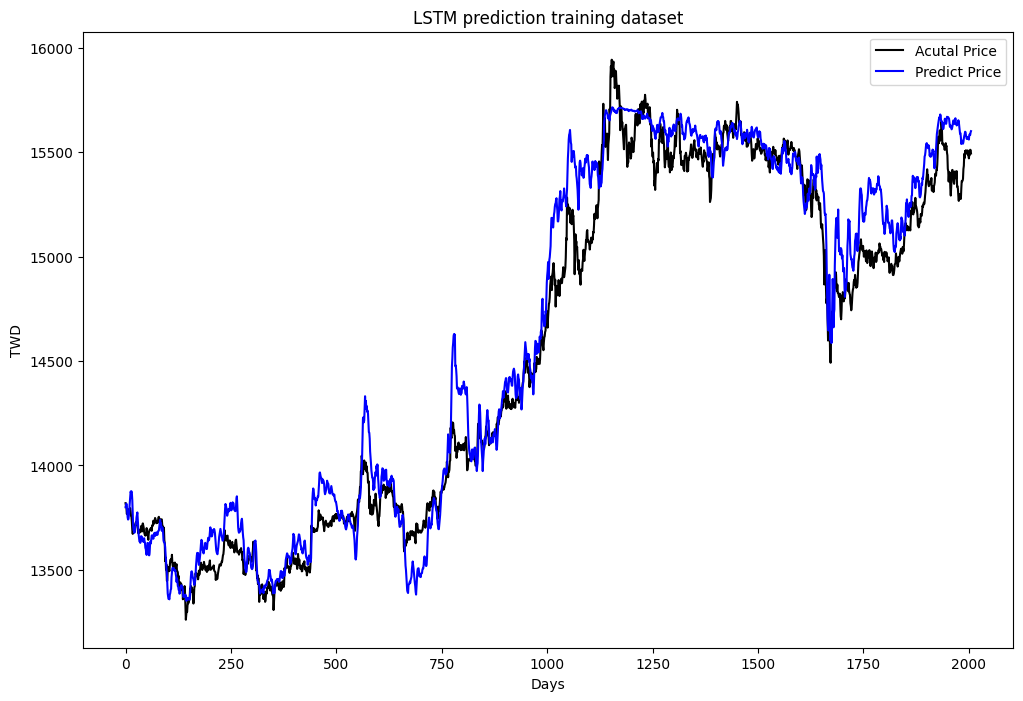

In [19]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('LSTM prediction training dataset')
plt.ylabel('BTC')
plt.xlabel('5 min time periods')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Testing dataset RMSE:354.1312780875054


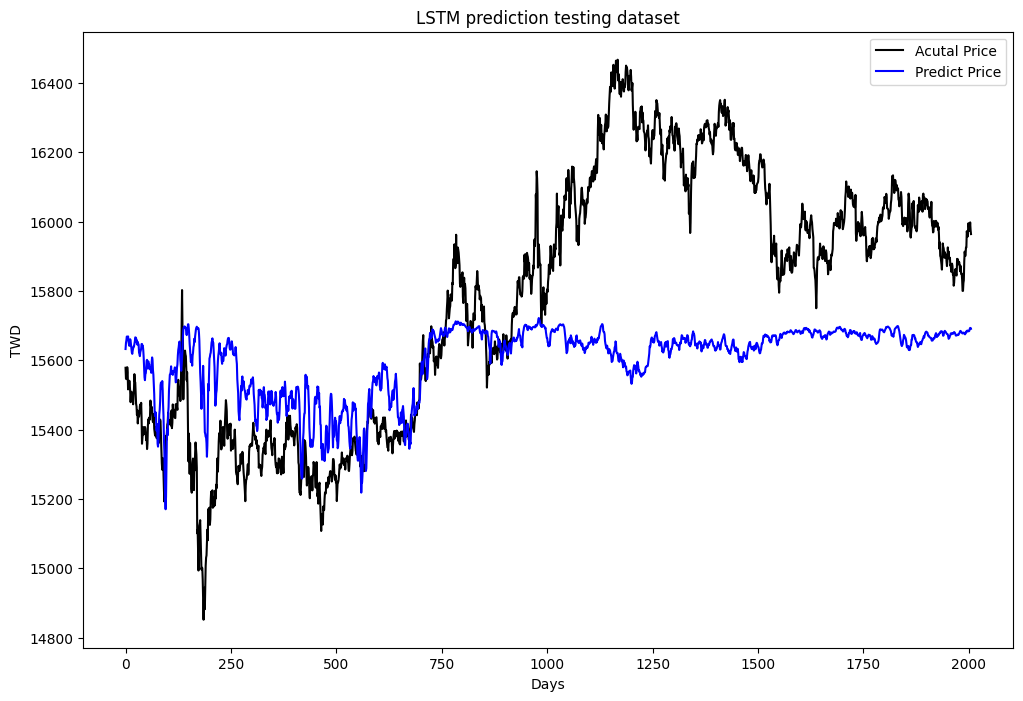

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('LSTM prediction testing dataset')
plt.ylabel('BTC')
plt.xlabel('5 min time periods')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Testing dataset RMSE:{RMSE}')